In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.tools import add_constant
from statsmodels.discrete.discrete_model import Logit
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, AdaBoostClassifier 
from sklearn.metrics import roc_auc_score,accuracy_score, precision_score,recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
def feature_importances_plot(model,names):
    feature_importances = 100*model.feature_importances_ / np.sum(gb.feature_importances_)
    feature_importances, feature_names, feature_idxs = \
    zip(*sorted(zip(feature_importances, names, range(len(names)))))

    width = 0.8

    idx = np.arange(len(names))
    plt.barh(idx, feature_importances, align='center', color = 'cyan')
    plt.yticks(idx, feature_names)

    plt.title("Feature Importances")
    plt.xlabel('Relative Importance of Feature', fontsize=14)
    plt.ylabel('Feature Name', fontsize=14)

#### Dataframe with less features

In [4]:
less = pd.read_csv('games_and_odds.csv')

#### Dataframe with more features

In [5]:
more = pd.read_csv('games_and_odds2.csv')

#### Drop rows that are draws for over/under

In [6]:
less.drop(less[(less.over_hit == 0) & (less.under_hit == 0)].index,inplace = True)

In [7]:
more.drop(more[(more.over_hit == 0) & (more.under_hit == 0)].index,inplace = True)

In [8]:
less.shape

(8873, 26)

In [9]:
more.shape

(8873, 46)

In [10]:
less.drop( ['Unnamed: 0',  'Date', 
       'home_team_score', 'visit_team_score', 
       'name',  'under_hit', 'favorite_covered',
       'underdog_covered'], axis = 1, inplace = True)

In [61]:
less.shape

(8873, 18)

In [11]:
more.drop( ['Unnamed: 0',  'Date', 
       'home_team_score', 'visit_team_score', 
       'name',  'under_hit', 'favorite_covered',
       'underdog_covered'], axis = 1, inplace = True)

In [62]:
more.shape

(8873, 38)

In [12]:
less.head()

,season,week,Home Team,Away Team,game_over_under,line,surface,weather_icon,temperature,wind_speed,wind_bearing,month,start,over_hit,Total Score Over Close,Total Score Under Close,Total Score Over Odds Range,Total Score Under Odds Range
0,1983,1,SF,PHI,40.0,-4.0,Grass,Clear Day,73.32,6.12,282.0,September,Night,0,1.936783,1.93928,0.070516,0.031869
1,1983,1,NO,ARI,37.0,-3.0,Dome,Dome,70.00,0.00,0.0,September,Day,1,1.936783,1.93928,0.070516,0.031869
2,1983,1,BUF,MIA,36.0,4.0,Turf,Partly Cloudy Day,78.95,10.67,194.0,September,Day,0,1.936783,1.93928,0.070516,0.031869
3,1983,1,CHI,ATL,38.0,-1.5,Grass,Clear Day,86.66,11.04,196.0,September,Day,0,1.936783,1.93928,0.070516,0.031869
4,1983,1,CIN,OAK,42.0,-2.0,Turf,Clear Day,82.18,7.90,194.0,September,Day,0,1.936783,1.93928,0.070516,0.031869


In [13]:
more.head()

,season,week,Home Team,Away Team,game_over_under,line,surface,weather_icon,temperature,wind_speed,...,Away Line Odds Max,Away Line Odds Close,Total Score Over Open,Total Score Over Min,Total Score Over Max,Total Score Over Close,Total Score Under Open,Total Score Under Min,Total Score Under Max,Total Score Under Close
0,1983,1,SF,PHI,40.0,-4.0,Grass,Clear Day,73.32,6.12,...,1.953855,1.945161,1.94425,1.905269,1.97977,1.940806,1.939312,1.929397,1.95124,1.943486
1,1983,1,NO,ARI,37.0,-3.0,Dome,Dome,70.00,0.00,...,1.953855,1.945161,1.94425,1.905269,1.97977,1.940806,1.939312,1.929397,1.95124,1.943486
2,1983,1,BUF,MIA,36.0,4.0,Turf,Partly Cloudy Day,78.95,10.67,...,1.953855,1.945161,1.94425,1.905269,1.97977,1.940806,1.939312,1.929397,1.95124,1.943486
3,1983,1,CHI,ATL,38.0,-1.5,Grass,Clear Day,86.66,11.04,...,1.953855,1.945161,1.94425,1.905269,1.97977,1.940806,1.939312,1.929397,1.95124,1.943486
4,1983,1,CIN,OAK,42.0,-2.0,Turf,Clear Day,82.18,7.90,...,1.953855,1.945161,1.94425,1.905269,1.97977,1.940806,1.939312,1.929397,1.95124,1.943486


#### Functions to ouput Accuracy and F1 Scores

In [14]:
def print_cv_scores(model,X_train,y_train ):
    f1= cross_val_score(model, X_train,y_train, cv = 10, scoring ='f1')
    precision = cross_val_score(model,X_train, y_train, cv = 10, scoring = 'precision')
    recall = cross_val_score(model,X_train,y_train, cv = 10, scoring = 'recall')
    print(f'Average Recall Score : {recall.mean()}')
    print(f'Average Precision Score : {precision.mean()}')   
    print(f'Average F1 Score : {f1.mean()}') 
    print(f'F1 Scores:{f1}')


### Training Sets With Less Features

#### without dummies

In [16]:
X = less.drop(['over_hit','season','week','Home Team', 'Away Team',
               'surface','weather_icon','month','start'], axis = 1)
y = less.over_hit

In [48]:
len(X.columns)

9

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

In [34]:
len(X_train.columns)

9

#### with surface, weather, and start dummies

In [354]:
dummies1 = pd.get_dummies(less['surface'],prefix ='surface')
dummies2 = pd.get_dummies(less['weather_icon'], prefix = 'weather')
dummies3 = pd.get_dummies(less['start'], prefix = 'start')
X_dummies = X.join(dummies1.loc[:,'surface_Grass':])
X_dummies = X_dummies.join(dummies2.loc[:, 'weather_Clear Night':])
X_dummies = X_dummies.join(dummies3.loc[:,'start_Late':])

In [355]:
X_dummies_train, X_dummies_test, y_train, y_test = train_test_split(X_dummies,y, test_size = 0.20)

### Training Sets With More Features

#### without dummies

In [58]:
X2 = more.drop(
            ['over_hit','season','week','Home Team', 'Away Team','surface','weather_icon','month','start'], 
            axis = 1)
y2 = more.over_hit

In [59]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,test_size = 0.2)

In [60]:
len(X2_train.columns)

29

In [31]:
X2_train.columns

Index(['game_over_under', 'line', 'temperature', 'wind_speed', 'wind_bearing',
       'Home Odds Open', 'Home Odds Min', 'Home Odds Max', 'Home Odds Close',
       'Away Odds Open', 'Away Odds Min', 'Away Odds Max', 'Away Odds Close',
       'Home Line Odds Open', 'Home Line Odds Min', 'Home Line Odds Max',
       'Home Line Odds Close', 'Away Line Odds Open', 'Away Line Odds Min',
       'Away Line Odds Max', 'Away Line Odds Close', 'Total Score Over Open',
       'Total Score Over Min', 'Total Score Over Max',
       'Total Score Over Close', 'Total Score Under Open',
       'Total Score Under Min', 'Total Score Under Max',
       'Total Score Under Close'],
      dtype='object')

#### with dummies

In [63]:
X2_dummies = X2.join(dummies1.loc[:,'surface_Grass':])
X2_dummies = X2_dummies.join(dummies2.loc[:, 'weather_Clear Night':])
X2_dummies = X2_dummies.join(dummies3.loc[:,'start_Late':])

In [64]:
X2_dummies_train, X2_dummies_test, y2_train, y2_test = train_test_split(X2_dummies, y2, test_size = 0.20)

In [65]:
len(X2_dummies_train.columns)

43

### Logistic Regression Less Features

#### without dummies

#### Standardized

In [66]:
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()
scale = StandardScaler().fit(X_train_stand)
X_train_stand = scale.transform(X_train_stand)
X_test_stand = scale.transform(X_test_stand)

In [67]:
logreg = LogisticRegression(solver = 'lbfgs')
print_cv_scores(logreg, X_train_stand, y_train)

Average Recall Score : 0.3847796879046879
Average Precision Score : 0.503493023120033
Average F1 Score : 0.43565431549495093
F1 Scores:[0.46153846 0.42765273 0.43564356 0.44891641 0.3973064  0.41883117
 0.43934426 0.4205298  0.43225806 0.47452229]


In [68]:
X_const = add_constant(X,prepend =True)
logit_model = Logit(y,X_const).fit()

Optimization terminated successfully.
         Current function value: 0.690905
         Iterations 4


In [69]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               over_hit   No. Observations:                 8873
Model:                          Logit   Df Residuals:                     8863
Method:                           MLE   Df Model:                            9
Date:                Thu, 27 Aug 2020   Pseudo R-squ.:                0.003169
Time:                        17:53:18   Log-Likelihood:                -6130.4
converged:                       True   LL-Null:                       -6149.9
Covariance Type:            nonrobust   LLR p-value:                 1.164e-05
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            7.3262      6.316      1.160      0.246      -5.054      19.706
game_over_under                 -0.0206      0.005     -4.399      0.000      -0.030      -0.011
line                            -0.0027      0.004     -0.752      0.452      -0.010       0.004
temperature                     -0.0011      0.001     -0.773      0.440      -0.004       0.002
wind_speed                      -0.0239      0.005     -4.859      0.000      -0.034      -0.014
wind_bearing                     0.0003      0.000      1.603      0.109    -7.3e-05       0.001
Total Score Over Close          -1.1042      1.819     -0.607      0.544      -4.669       2.461
Total Score Under Close         -2.2448      1.790     -1.254      0.210      -5.754       1.264
Total Score Over Odds Range      1.2549      1.100      1.141      0.254      -0.901       3.411
Total Score Under Odds Range     1.8828      1.781      1.057      0.290      -1.607       5.373
================================================================================================
"""

In [ ]:
logreg = LogisticRegression(solver = 'lbfgs')
print_test_scores(logreg, X_train_stand, X_test_stand,y_train, y_test)

#### Not Standardized

In [70]:
logreg = LogisticRegression(solver = 'lbfgs')
print_cv_scores(logreg, X_train,y_train)

Average Recall Score : 0.37255487567987566
Average Precision Score : 0.5047398318417418
Average F1 Score : 0.42815884480630706
F1 Scores:[0.46412214 0.41967213 0.40609137 0.44724409 0.38383838 0.42019544
 0.4375     0.41008403 0.44186047 0.45098039]


In [ ]:
logreg = LogisticRegression(solver = 'lbfgs')
print_test_scores(logreg, X_train, X_test, y_train, y_test)

#### with dummies 

In [71]:
logreg = LogisticRegression(solver = 'lbfgs', max_iter = 1000)
print_cv_scores(logreg, X_dummies_train,y_train)

Average Recall Score : 0.5214581714581714
Average Precision Score : 0.516020674298699
Average F1 Score : 0.5185144594671721
F1 Scores:[0.53611111 0.54338549 0.51948052 0.48245614 0.51267606 0.50909091
 0.52149792 0.51841746 0.5        0.54202899]


In [155]:
logreg = LogisticRegression(solver = 'lbfgs', max_iter = 2000)
print_cv_scores(logreg, X_dummies_train,y_train)

Average Recall Score : 0.48010724519033976
Average Precision Score : 0.5210394845836572
Average F1 Score : 0.4995969415208095
F1 Scores:[0.48235294 0.47005988 0.52352941 0.55522388 0.48882265 0.48802395
 0.49160305 0.48316252 0.49637155 0.51681957]


#### Lasso For Feature Engineering

In [180]:
names = X_train.columns
lasso = Lasso(alpha=0.1)
lasso_coef = lasso.fit(X_train,y_train).coef_

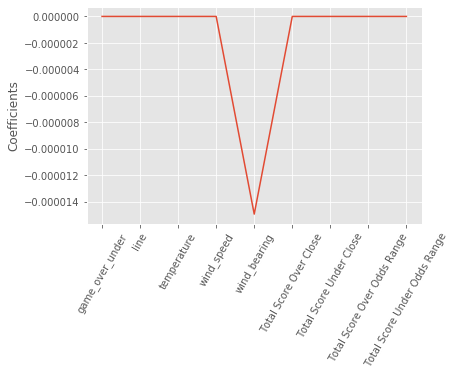

In [181]:
_ = plt.plot(range(len(names)), lasso_coef)
_ = plt.xticks(range(len(names)), names, rotation =60)
_=plt.ylabel('Coefficients')

#### less features

In [304]:
X3 =less[['wind_bearing','game_over_under', 'line','Total Score Over Close','Total Score Under Close',
           'Total Score Over Odds Range','Total Score Under Odds Range'
         ]].join(dummies1.loc[:,'surface_Grass':])
X3 = X3.join(dummies2.loc[:, 'weather_Clear Night':])
X3 = X3.join(dummies3.loc[:,'start_Late':])
#X3 = X3.join(dummies4.loc[:,'month_December':])
#X3 = X3.join(dummies5.loc[:,'week_2':])

In [305]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size = 0.20)

In [306]:
logreg = LogisticRegression()
print_cv_scores(logreg, X3_train, y3_train)

Average Recall Score : 0.5654690857006446
Average Precision Score : 0.5185343960460057
Average F1 Score : 0.5407413544839523
F1 Scores:[0.54847645 0.54520918 0.55764075 0.51023192 0.52785146 0.52558783
 0.55689424 0.56126482 0.52998605 0.54427083]


With month and week dummies

In [347]:
X4 =less[['wind_bearing','game_over_under','line','Total Score Over Close','Total Score Under Close',
          'Total Score Over Odds Range', 'Total Score Under Odds Range'
         ]].join(dummies1.loc[:,'surface_Grass':])
X4 = X4.join(dummies2.loc[:, 'weather_Clear Night':])
X4 = X4.join(dummies3.loc[:,'start_Late':])
X4 = X4.join(dummies4.loc[:,'month_December':])
X4 = X4.join(dummies5.loc[:,'week_2':])

In [348]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4,y, test_size = 0.2)

In [349]:
logreg = LogisticRegression()
print_cv_scores(logreg, X4_train, y4_train)

Average Recall Score : 0.47286001036001035
Average Precision Score : 0.5090827197027117
Average F1 Score : 0.4900511165437746
F1 Scores:[0.48153619 0.47413793 0.53485064 0.4828614  0.47926267 0.46666667
 0.4664723  0.49411765 0.50733138 0.51327434]


#### more features

In [359]:
more.columns

Index(['season', 'week', 'Home Team', 'Away Team', 'game_over_under', 'line',
       'surface', 'weather_icon', 'temperature', 'wind_speed', 'wind_bearing',
       'month', 'start', 'over_hit', 'Home Odds Open', 'Home Odds Min',
       'Home Odds Max', 'Home Odds Close', 'Away Odds Open', 'Away Odds Min',
       'Away Odds Max', 'Away Odds Close', 'Home Line Odds Open',
       'Home Line Odds Min', 'Home Line Odds Max', 'Home Line Odds Close',
       'Away Line Odds Open', 'Away Line Odds Min', 'Away Line Odds Max',
       'Away Line Odds Close', 'Total Score Over Open', 'Total Score Over Min',
       'Total Score Over Max', 'Total Score Over Close',
       'Total Score Under Open', 'Total Score Under Min',
       'Total Score Under Max', 'Total Score Under Close'],
      dtype='object')

In [360]:
X5 =more[[ 'game_over_under', 'line',
        'wind_bearing',
        'Home Odds Open', 'Home Odds Min',
       'Home Odds Max', 'Home Odds Close', 'Away Odds Open', 'Away Odds Min',
       'Away Odds Max', 'Away Odds Close', 'Home Line Odds Open',
       'Home Line Odds Min', 'Home Line Odds Max', 'Home Line Odds Close',
       'Away Line Odds Open', 'Away Line Odds Min', 'Away Line Odds Max',
       'Away Line Odds Close', 'Total Score Over Open', 'Total Score Over Min',
       'Total Score Over Max', 'Total Score Over Close',
       'Total Score Under Open', 'Total Score Under Min',
       'Total Score Under Max', 'Total Score Under Close']
         ].join(dummies1.loc[:,'surface_Grass':])
X5 = X5.join(dummies2.loc[:, 'weather_Clear Night':])
X5 = X5.join(dummies3.loc[:,'start_Late':])

In [361]:
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y, test_size = 0.20)

In [364]:
logreg = LogisticRegression()
print_cv_scores(logreg, X5_train, y5_train)

Average Recall Score : 0.5575847057505481
Average Precision Score : 0.5203030426429843
Average F1 Score : 0.5380165711555395
F1 Scores:[0.52027972 0.5414966  0.51104972 0.51621622 0.55661664 0.54232804
 0.53783784 0.55747126 0.55238095 0.54448871]


#### Hyperparameter Tuning

In [72]:
c_space = np.logspace(-5,8,15)
param_grid = {'C':c_space}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg,param_grid, cv = 10, scoring = 'f1')
logreg_cv.fit(X_dummies_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08])},
             pre_dispatch='2*n_jobs', ref

In [73]:
logreg_cv.best_params_

{'C': 100000000.0}

In [74]:
logreg_cv.best_score_

0.5194937713765791

In [75]:
logreg = LogisticRegression(C = 100000000.0)
print_cv_scores(logreg,X_dummies_train,y_train )

Average Recall Score : 0.5240157990157991
Average Precision Score : 0.5154076620222298
Average F1 Score : 0.5195000510870409
F1 Scores:[0.53910615 0.55448276 0.52074392 0.48609078 0.5077574  0.50704225
 0.51117318 0.52472527 0.50209205 0.54178674]


After Lasso Feature Engineering

less features

In [350]:
c_space = np.logspace(-5,8,15)
param_grid = {'C':c_space}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg,param_grid, cv = 10, scoring = 'f1')
logreg_cv.fit(X3_train,y3_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08])},
             pre_dispatch='2*n_jobs', ref

In [351]:
logreg_cv.best_params_

{'C': 31.622776601683793}

In [352]:
logreg_cv.best_score_

0.5422865788351315

In [353]:
logreg = LogisticRegression(C = 31.622776601683793)
print_cv_scores(logreg,X3_train,y3_train )

Average Recall Score : 0.5682899657834011
Average Precision Score : 0.5190194219830773
Average F1 Score : 0.5422867952309178
F1 Scores:[0.54495159 0.54324324 0.56458056 0.5156038  0.53104359 0.52981969
 0.56349206 0.55936675 0.53481894 0.53594771]


#### Standardize Tuned Model

In [373]:
X3_train_stand = X3_train.copy()
X3_test_stand = X3_test.copy()
scale = StandardScaler().fit(X3_train_stand)
X3_train_stand = scale.transform(X3_train_stand)
X3_test_stand = scale.transform(X3_test_stand)

In [379]:
logreg = LogisticRegression(C = 31.622776601683793)
print_cv_scores(logreg, X3_train_stand, y3_train)

Average Recall Score : 0.5665966419988859
Average Precision Score : 0.5170373308914658
Average F1 Score : 0.5403959341567818
F1 Scores:[0.53888889 0.54324324 0.56084656 0.51761518 0.53104359 0.52704577
 0.5615894  0.55789474 0.52793296 0.53785901]


more features

In [365]:
c_space = np.logspace(-5,8,15)
param_grid = {'C':c_space}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg,param_grid, cv = 10, scoring = 'f1')
logreg_cv.fit(X5_train,y5_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08])},
             pre_dispatch='2*n_jobs', ref

In [366]:
logreg_cv.best_params_

{'C': 3.727593720314938}

In [367]:
logreg_cv.best_score_

0.5372046021127516

In [368]:
logreg = LogisticRegression(C = 3.727593720314938)
print_cv_scores(logreg, X5_train, y5_train)

Average Recall Score : 0.5581488772586866
Average Precision Score : 0.518381551880694
Average F1 Score : 0.5372144612212042
F1 Scores:[0.51820728 0.54986523 0.51104972 0.51682369 0.55266758 0.53473132
 0.53638814 0.56160458 0.55163043 0.53917663]


### Logistic Regression Model With More Features

#### Without Dummies

In [76]:
logreg = LogisticRegression(solver = 'lbfgs', max_iter = 2000)
print_cv_scores(logreg, X2_train, y2_train)

Average Recall Score : 0.3779663623413623
Average Precision Score : 0.5057457983887679
Average F1 Score : 0.4318400830328584
F1 Scores:[0.39338843 0.46405229 0.44827586 0.43405676 0.42700157 0.40344828
 0.42675159 0.45941807 0.42281879 0.43918919]


In [ ]:
logreg = LogisticRegression(solver = 'lbfgs', max_iter = 2000)
model_prediction_scores(logreg,X2_train, X2_test, y2_train, y2_test )

#### with dummies

In [78]:
logreg = LogisticRegression(solver = 'lbfgs', max_iter = 2000)
print_cv_scores(logreg, X2_dummies_train,y2_train)

Average Recall Score : 0.516661001036001
Average Precision Score : 0.5176485527140905
Average F1 Score : 0.5169728545523709
F1 Scores:[0.52360515 0.52981969 0.52906977 0.5243553  0.52706553 0.52089136
 0.48       0.46713287 0.54778887 0.52      ]


In [ ]:
logreg = LogisticRegression(solver = 'lbfgs', max_iter =1000)
model_prediction_scores(logreg, X2_dummies_train, X2_dummies_test, y2_train, y2_test)

### Decision Tree With Less Features

#### without dummies

In [79]:
dt = DecisionTreeClassifier()
print_cv_scores(dt, X_train, y_train)

Average Recall Score : 0.49475038850038844
Average Precision Score : 0.5079522623478916
Average F1 Score : 0.5043847534231173
F1 Scores:[0.52050919 0.49712644 0.49438202 0.49781659 0.52906977 0.46627566
 0.51893408 0.49484536 0.50647482 0.5184136 ]


#### with dummies

In [81]:
dt = DecisionTreeClassifier()
print_cv_scores(dt, X_dummies_train, y_train)

Average Recall Score : 0.4936026936026936
Average Precision Score : 0.5049988613206382
Average F1 Score : 0.5004120697160962
F1 Scores:[0.50946143 0.47521866 0.45925926 0.50919378 0.49507736 0.47507331
 0.50940666 0.53125    0.53802817 0.50215208]


In [160]:
dt = DecisionTreeClassifier()
print_cv_scores(dt, X_dummies_train, y_train)

Average Recall Score : 0.4907106017191977
Average Precision Score : 0.49372499245299084
Average F1 Score : 0.4884145227564088
F1 Scores:[0.48920863 0.43348281 0.4813278  0.53055556 0.48       0.4870317
 0.50442478 0.48773449 0.50980392 0.48057554]


### Decision Tree with more features

#### without dummies

In [82]:
dt = DecisionTreeClassifier()
print_cv_scores(dt,X2_train, y2_train)

Average Recall Score : 0.4787781662781662
Average Precision Score : 0.5014698397496477
Average F1 Score : 0.4922991598196532
F1 Scores:[0.50445104 0.47953216 0.47230321 0.51936872 0.51209104 0.510699
 0.49127907 0.46407186 0.50857143 0.46062407]


#### with dummies

In [83]:
dt = DecisionTreeClassifier()
print_cv_scores(dt, X2_dummies_train,y2_train)

Average Recall Score : 0.4958640896140897
Average Precision Score : 0.4993966361995169
Average F1 Score : 0.4951468731960727
F1 Scores:[0.52601156 0.48535565 0.48335745 0.46539028 0.52074392 0.50828729
 0.46518519 0.50493653 0.50072359 0.49147727]


#### Hyperparamter Tuning


#### Decision Tree with less features and no dummies

In [94]:
param_grid = {'max_depth':list(range(1,20)), 'max_features': list(range(1,10)), 
              'min_samples_leaf': list(range(1,10)), 'criterion':['gini','entropy']}

In [105]:
tree = DecisionTreeClassifier()
tree_cv = RandomizedSearchCV(tree, param_grid, cv = 10, n_jobs =-1, scoring = 'f1')

In [106]:
tree_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
                                                    splitter='best'

In [107]:
tree_cv.best_params_

{'min_samples_leaf': 9,
 'max_features': 2,
 'max_depth': 17,
 'criterion': 'entropy'}

In [108]:
tree_cv.best_score_

0.4504187167728806

In [109]:
dt= DecisionTreeClassifier(criterion = 'entropy',
                           max_depth = 17, 
                           max_features = 2, 
                           min_samples_leaf = 9)

print_cv_scores(dt, X_train, y_train)

Average Recall Score : 0.37679114866614866
Average Precision Score : 0.5024293133166875
Average F1 Score : 0.4347263683167445
F1 Scores:[0.38421955 0.4020979  0.51523546 0.41733547 0.44761905 0.4606414
 0.41930116 0.42532468 0.40747029 0.46801872]


#### less features with dummies

In [101]:
tree = DecisionTreeClassifier()
tree_cv = RandomizedSearchCV(tree, param_grid, cv = 10,n_jobs =-1, scoring = 'f1')
tree_cv.fit(X_dummies_train,y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
                                                    splitter='best'

In [102]:
tree_cv.best_params_

{'min_samples_leaf': 3,
 'max_features': 5,
 'max_depth': 13,
 'criterion': 'entropy'}

In [103]:
tree_cv.best_score_

0.5442352272953057

In [104]:
dt = DecisionTreeClassifier(criterion= 'entropy',
 max_depth= 13,
 max_features= 5,
 min_samples_leaf= 3)
print_cv_scores(dt,X_dummies_train, y_train)

Average Recall Score : 0.569744722869723
Average Precision Score : 0.49061319526116787
Average F1 Score : 0.5003482802866065
F1 Scores:[0.5107604  0.54689564 0.56296296 0.39619651 0.51820728 0.47407407
 0.54862843 0.53386454 0.46599132 0.44590164]


### Random Forest With Less Features

#### without dummies

In [110]:
rf = RandomForestClassifier()
print_cv_scores(rf, X_train, y_train)

Average Recall Score : 0.4023868492618493
Average Precision Score : 0.5036206401447129
Average F1 Score : 0.44308254529336244
F1 Scores:[0.47878788 0.40842788 0.4091653  0.43681747 0.47425897 0.4591195
 0.45987654 0.41733547 0.45253165 0.43450479]


#### with dummies

In [111]:
rf= RandomForestClassifier ()
print_cv_scores(rf, X_dummies_train, y_train)

Average Recall Score : 0.40493881118881125
Average Precision Score : 0.503643711997123
Average F1 Score : 0.45386202066468473
F1 Scores:[0.43548387 0.46082949 0.43653251 0.47926267 0.46248086 0.43226788
 0.45635528 0.45070423 0.44936709 0.47533632]


In [162]:
rf= RandomForestClassifier ()
print_cv_scores(rf, X_dummies_train, y_train)

Average Recall Score : 0.40857470323372896
Average Precision Score : 0.5021354045505417
Average F1 Score : 0.44058512176818415
F1 Scores:[0.4278607  0.40894569 0.40722496 0.45723173 0.45151033 0.4502447
 0.45410628 0.41311475 0.43561208 0.5       ]


### Random Forest With More Features

#### without dummies

In [112]:
rf = RandomForestClassifier()
print_cv_scores(rf, X2_train, y2_train)

Average Recall Score : 0.4169734200984202
Average Precision Score : 0.5098332633336573
Average F1 Score : 0.43714519851785055
F1 Scores:[0.41017488 0.45705024 0.4024961  0.4546851  0.41883117 0.42519685
 0.4648318  0.40770465 0.46246246 0.46801872]


#### with dummies

In [113]:
rf = RandomForestClassifier()
print_cv_scores(rf, X2_dummies_train, y2_train)

Average Recall Score : 0.4058736402486403
Average Precision Score : 0.49106417152847026
Average F1 Score : 0.4384556298904377
F1 Scores:[0.41640379 0.43518519 0.42022117 0.46769231 0.43209877 0.43225806
 0.42122186 0.44135802 0.44827586 0.46984127]


#### Hyperparameter Tuning

#### without dummies

In [ ]:
import numpy as np

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]


In [ ]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf = RandomForestClassifier()
rf_cv = RandomizedSearchCV(rf, random_grid, n_iter = 100,cv = 3)
rf_cv.fit(Xrf_train, yrf_train)

In [ ]:
rf_cv.best_params_

In [ ]:
rf_cv.best_score_

In [ ]:
rf = RandomForestClassifier(n_estimators = 400,
 min_samples_split = 10,
 min_samples_leaf= 2,
 max_features= 'sqrt',
 max_depth= 100,
 )
model_prediction_scores(rf, Xrf_train, Xrf_test, yrf_train, yrf_test)

### AdaBoost With Less Features

#### without dummies

In [114]:
dt = DecisionTreeClassifier()
ada = AdaBoostClassifier(base_estimator = dt)
print_cv_scores(ada, X_train, y_train)

Average Recall Score : 0.5038283475783476
Average Precision Score : 0.507841596049966
Average F1 Score : 0.4954402911697485
F1 Scores:[0.50771388 0.48185776 0.49928673 0.51282051 0.49630724 0.48082596
 0.52574526 0.5        0.47283407 0.47701149]


#### with dummies

In [115]:
dt = DecisionTreeClassifier()
ada = AdaBoostClassifier(base_estimator = dt)
print_cv_scores(ada, X_dummies_train, y_train)


Average Recall Score : 0.5089500777000777
Average Precision Score : 0.5127062954140154
Average F1 Score : 0.5113442154217379
F1 Scores:[0.51800554 0.5243553  0.49275362 0.51317614 0.49162011 0.5192582
 0.50276243 0.49431818 0.54862119 0.50857143]


### AdaBoost With More Features

#### no dummies

In [116]:
dt = DecisionTreeClassifier()
ada = AdaBoostClassifier(base_estimator = dt)
print_cv_scores(ada, X2_train, y2_train)

Average Recall Score : 0.4955743330743331
Average Precision Score : 0.49653007279593836
Average F1 Score : 0.4916492829051191
F1 Scores:[0.48093842 0.45400593 0.4972067  0.50139276 0.52454418 0.54022989
 0.48373409 0.48979592 0.49142857 0.45321637]


#### with dummies

In [117]:
dt = DecisionTreeClassifier()
ada = AdaBoostClassifier(base_estimator = dt)
print_cv_scores(ada, X2_dummies_train, y2_train)

Average Recall Score : 0.5012788137788139
Average Precision Score : 0.5069351857959876
Average F1 Score : 0.49117314752490754
F1 Scores:[0.509299   0.47819972 0.48       0.4628821  0.49283668 0.50211566
 0.48656294 0.52558783 0.49271137 0.48153619]


### Gradient Boost With Less Features

#### without dummies

In [118]:
gb = GradientBoostingClassifier()
print_cv_scores(gb, X_train, y_train)

Average Recall Score : 0.38561981999482
Average Precision Score : 0.5063726773895523
Average F1 Score : 0.4373905847213243
F1 Scores:[0.44551282 0.4416     0.46251994 0.44620253 0.4184514  0.42345277
 0.4274571  0.41186161 0.45276873 0.44407895]


#### with dummies


In [119]:
gb = GradientBoostingClassifier()
print_cv_scores(gb, X_dummies_train, y_train)

Average Recall Score : 0.5399297461797461
Average Precision Score : 0.5119955637234733
Average F1 Score : 0.5249503166137774
F1 Scores:[0.50363901 0.52883263 0.5308311  0.50434783 0.49447514 0.52949246
 0.52861035 0.52910053 0.55675676 0.54341737]


In [124]:
gb = GradientBoostingClassifier(n_estimators = 200)
print_cv_scores(gb, X_dummies_train, y_train)

Average Recall Score : 0.5447560541310541
Average Precision Score : 0.5119705645156291
Average F1 Score : 0.5283421186456174
F1 Scores:[0.53038674 0.56608812 0.51728907 0.49855908 0.50884354 0.51253482
 0.54155496 0.54205607 0.53333333 0.53277545]


In [133]:
gb = GradientBoostingClassifier(n_estimators = 300)
print_cv_scores(gb, X_dummies_train, y_train)

Average Recall Score : 0.5453250453250453
Average Precision Score : 0.517705964910173
Average F1 Score : 0.5308380715852501
F1 Scores:[0.51339915 0.55795148 0.50904033 0.51274788 0.51771117 0.52808989
 0.54912517 0.55359566 0.52793296 0.53878702]


In [134]:
gb = GradientBoostingClassifier(n_estimators = 400)
print_cv_scores(gb, X_dummies_train, y_train)

Average Recall Score : 0.5368006993006993
Average Precision Score : 0.5167001643597603
Average F1 Score : 0.5265147269388942
F1 Scores:[0.53465347 0.56492637 0.51239669 0.49271137 0.48391608 0.51195499
 0.53959732 0.53772291 0.54494382 0.54232425]


### Gradient Boost With More Features

#### no dummies

In [122]:
gb = GradientBoostingClassifier()
print_cv_scores(gb, X2_train, y2_train)

Average Recall Score : 0.42465763403263407
Average Precision Score : 0.49894765635091803
Average F1 Score : 0.45892214515887686
F1 Scores:[0.4622093  0.46614173 0.43492063 0.45354331 0.4813154  0.465625
 0.45877061 0.47164179 0.43818466 0.45686901]


#### with dummies

In [123]:
gb = GradientBoostingClassifier()
print_cv_scores(gb, X2_dummies_train, y2_train)

Average Recall Score : 0.5047178515928517
Average Precision Score : 0.5042550090510004
Average F1 Score : 0.5032504330836212
F1 Scores:[0.45722714 0.53441296 0.53825137 0.49045521 0.52034884 0.4619883
 0.50647482 0.47042641 0.53314528 0.51977401]


#### Hyperparameter Tuning

In [138]:
from xgboost import XGBClassifier
param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
                          'max_depth': [2, 4, 6],
                          'min_samples_leaf': [1, 2, 5, 10],
                          'max_features': [1.0, 0.3, 0.1],
                          'n_estimators': [300, 500,750,1000]}

xgb = XGBClassifier()
xgb_cv = GridSearchCV(xgb,param_grid, n_jobs = -1, cv =10, scoring = 'f1')
xgb_cv.fit(X_dummies_train,y_train)


[23:52:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { max_features, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constra...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.0

In [139]:
xgb_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 6,
 'max_features': 1.0,
 'min_samples_leaf': 1,
 'n_estimators': 300}

In [140]:
xgb_cv.best_score_

0.5352142011371854

In [387]:
gb =GradientBoostingClassifier(learning_rate =0.01,
                               max_depth = 6,
                               max_features = 1.0,
                               min_samples_leaf=1,
                               n_estimators= 300)
print_cv_scores(gb,X_dummies_train,y_train)

Average Recall Score : 0.5749822946175638
Average Precision Score : 0.5184907705935113
Average F1 Score : 0.5437742989761511
F1 Scores:[0.57512953 0.53182461 0.56225931 0.54374159 0.56957087 0.55388813
 0.48801128 0.51339915 0.55813953 0.54177898]


In [389]:
gb.fit(X_dummies_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=6,
                           max_features=1.0, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Text(0, 0.5, 'Feature Name')

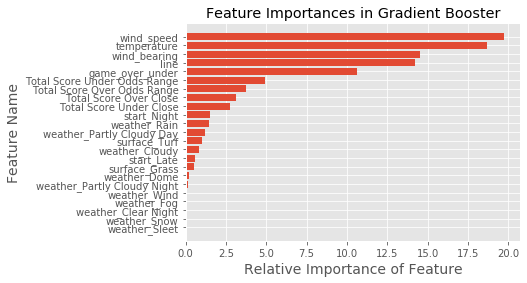

In [390]:
names  = X_dummies_train.columns 
feature_importances = 100*gb.feature_importances_ / np.sum(gb.feature_importances_)
feature_importances, feature_names, feature_idxs = \
    zip(*sorted(zip(feature_importances, names, range(len(names)))))

width = 0.8

idx = np.arange(len(names))
plt.barh(idx, feature_importances, align='center')
plt.yticks(idx, feature_names)

plt.title("Feature Importances in Gradient Booster")
plt.xlabel('Relative Importance of Feature', fontsize=14)
plt.ylabel('Feature Name', fontsize=14)

In [393]:
X6 = X_dummies[['game_over_under', 'line', 'temperature', 'wind_speed', 'wind_bearing',
       'Total Score Over Close', 'Total Score Under Close',
       'Total Score Over Odds Range', 'Total Score Under Odds Range',
       'surface_Grass', 'surface_Turf',
       'weather_Cloudy', 'weather_Dome',
       'weather_Partly Cloudy Day', 'weather_Partly Cloudy Night',
       'weather_Rain', 'start_Late', 'start_Night']]



In [403]:
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y, test_size = 0.20)

In [405]:
X6_train.shape

(7098, 18)

In [404]:
gb =GradientBoostingClassifier(learning_rate =0.01,
                               max_depth = 6,
                               max_features = 1.0,
                               min_samples_leaf=1,
                               n_estimators= 300)
print_cv_scores(gb,X6_train,y6_train)

Average Recall Score : 0.47479609279609286
Average Precision Score : 0.5091866530685781
Average F1 Score : 0.4855493457841261
F1 Scores:[0.47703704 0.4549483  0.51014493 0.50647482 0.47129909 0.50666667
 0.49339207 0.48211509 0.42813456 0.5252809 ]


In [406]:

param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
                          'max_depth': [2, 4, 6],
                          'min_samples_leaf': [1, 2, 5, 10],
                          'max_features': [1.0, 0.3, 0.1],
                          'n_estimators': [300, 500,750,1000]}

xgb = XGBClassifier()
xgb_cv = GridSearchCV(xgb,param_grid, n_jobs = -1, cv =5, scoring = 'f1')
xgb_cv.fit(X6_train,y6_train)


[06:34:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { max_features, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constrai...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.0

In [397]:
xgb_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 2,
 'max_features': 1.0,
 'min_samples_leaf': 1,
 'n_estimators': 300}

In [398]:
xgb_cv.best_score_

0.6140725542170717

In [400]:
gb = GradientBoostingClassifier(learning_rate= 0.01,
                                 max_depth = 2,
                                 max_features= 1.0,
                                 min_samples_leaf=1,
                                 n_estimators =300)
print_cv_scores(gb, X6_train, y6_train)

Average Recall Score : 0.7519225967540575
Average Precision Score : 0.5393123506035327
Average F1 Score : 0.6276101205031852
F1 Scores:[0.62222222 0.65486726 0.6        0.62857143 0.62162162 0.64840183
 0.61320755 0.61395349 0.62325581 0.65      ]


## TESTING!!!

### Non-Standardized Tuned Logistc Regression Model

In [380]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size = 0.20)

In [382]:
logreg = LogisticRegression(C = 31.622776601683793)
logreg.fit(X3_train,y3_train)
y_pred = logreg.predict(X3_test)
print(f'Recall score : {recall_score(y3_test,y_pred)}')
print(f'Precision score : {precision_score(y3_test, y_pred)}')
print(f'F1 score : {f1_score(y3_test, y_pred)}')

Recall score : 0.5852803738317757
Precision score : 0.499003984063745
F1 score : 0.5387096774193548


### Standardized Tuned Logistc Regression Model

In [383]:
X3_train_stand = X3_train.copy()
X3_test_stand = X3_test.copy()
scale = StandardScaler().fit(X3_train_stand)
X3_train_stand = scale.transform(X3_train_stand)
X3_test_stand = scale.transform(X3_test_stand)

In [384]:
logreg = LogisticRegression(C = 31.622776601683793)
logreg.fit(X3_train_stand,y3_train)
y_pred = logreg.predict(X3_test_stand)
print(f'Recall score : {recall_score(y3_test,y_pred)}')
print(f'Precision score : {precision_score(y3_test, y_pred)}')
print(f'F1 score : {f1_score(y3_test, y_pred)}')

Recall score : 0.5841121495327103
Precision score : 0.499001996007984
F1 score : 0.5382131324004306


### Tuned GradientBoost

In [385]:
X_dummies_train, X_dummies_test, y_train, y_test = train_test_split(X_dummies,y, test_size = 0.20)

In [386]:
gb =GradientBoostingClassifier(learning_rate =0.01,
                               max_depth = 6,
                               max_features = 1.0,
                               min_samples_leaf=1,
                               n_estimators= 300)
gb.fit(X_dummies_train, y_train)
y_pred = gb.predict(X_dummies_test)
print(f'Recall score : {recall_score(y_test,y_pred)}')
print(f'Precision score : {precision_score(y_test, y_pred)}')
print(f'F1 score : {f1_score(y_test, y_pred)}')

Recall score : 0.5859284890426759
Precision score : 0.4946445959104187
F1 score : 0.5364308342133053
